<a href="https://colab.research.google.com/github/LjBLincoln/Machine_Learning/blob/master/wx+b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Create Train Data and Test Data**

In [0]:
import os

import numpy as np 

TRAIN_DATA = 1000
TEST_DATA = 1000

TRAIN_DATA_FILE =  'train'
TEST_DATA_FILE =  'test'



def create_DATA(file,type):
    if (os.path.isfile(file)):
        data = np.loadtxt(file)
    else:
        x_batch = np.linspace(0, 2, type).astype(np.float32).reshape(type,1) #np.random.rand(type).astype(np.float32)
        y_batch = (1.5 * x_batch + np.random.randn(*x_batch.shape) * 0.2 + 0.5).reshape(type,1)
        #print(x_batch)
        #print(y_batch)
        data = np.hstack((x_batch,y_batch))
    #print(data)
    np.savetxt(file,data)
  
create_DATA(TRAIN_DATA_FILE,TRAIN_DATA)
create_DATA(TEST_DATA_FILE,TEST_DATA)

# **Create TFRecord **

In [0]:
# -*- coding: utf-8 -*-
import os 
import tensorflow as tf

TRAIN_DATA_FILE = 'train'
TEST_DATA_FILE = 'test'

def _float_feature(value):
    return tf.train.Feature(float_list = tf.train.FloatList(value = [value]))
  
def create_TFRecord(file):
    classes = np.loadtxt(file)
    #print(classes) 
    writer = tf.python_io.TFRecordWriter(file +'.tfrecords')

    for index, data in enumerate(classes):
     # print(index,data[0],data[1]) 
      example = tf.train.Example(features = tf.train.Features(feature = {"y_data": _float_feature(data[1]),
                                                                         "x_data": _float_feature(data[0]),                                                                          
                                                                        }))
      writer.write(example.SerializeToString()) 
    writer.close()
  
create_TFRecord(TRAIN_DATA_FILE)
create_TFRecord(TEST_DATA_FILE)

# **Read TFRecord **

In [0]:
import tensorflow as tf

from tensorflow.contrib.learn.python.learn.datasets import base


def pares_tfrecorder(serialized_example):
    features = tf.parse_single_example(serialized_example,
                                       features={
                                           'x_data': tf.FixedLenFeature([], tf.float32),
                                           'y_data' : tf.FixedLenFeature([], tf.float32),
                                       })

    X_ = tf.cast(features['x_data'], tf.float32)
    Y_ = tf.cast(features['y_data'], tf.float32) 

    return X_,Y_

def read_and_decode_two(filename,batch):
    dataset = tf.data.TFRecordDataset(filename)
    #print(dataset)
    dataset = dataset.map(pares_tfrecorder)
    dataset = dataset.batch(batch).repeat(1)
    
    return dataset



# Demo (y = wx+b)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
After 0  step(s), loss is 1.0698, weight is 0.0716376 , bias is 1.89796
After 50  step(s), loss is 0.0431684, weight is 1.45298 , bias is 0.52037
Adding run metadata fro  99
After 99  step(s), loss is 0.0430775, weight is 1.48981 , bias is 0.504302
After 100  step(s), loss is 0.0430775, weight is 1.48987 , bias is 0.504275
After 150  step(s), loss is 0.0430775, weight is 1.4907 , bias is 0.503928
Adding run metadata fro  199
After 199  step(s), loss is 0.0430775, weight is 1.49072 , bias is 0.50392
After 200  step(s), loss is 0.0430775, weight is 1.49072 , bias is 0.50392
After 250  step(s), loss is 0.0430775, weight is 1.49072 , bias is 0.50392
Adding run metadata fro  299
After 299  step(s), loss is 0.0430775, weight is 1.49072 , bias is 0.50392
After 300  step(s), loss is 0.0430775, weight is 1.49072 , bias is 0.50392
After 350  step(s), loss is 0.0430775, weight is 1.49072 , bias is 0.50392
Adding ru

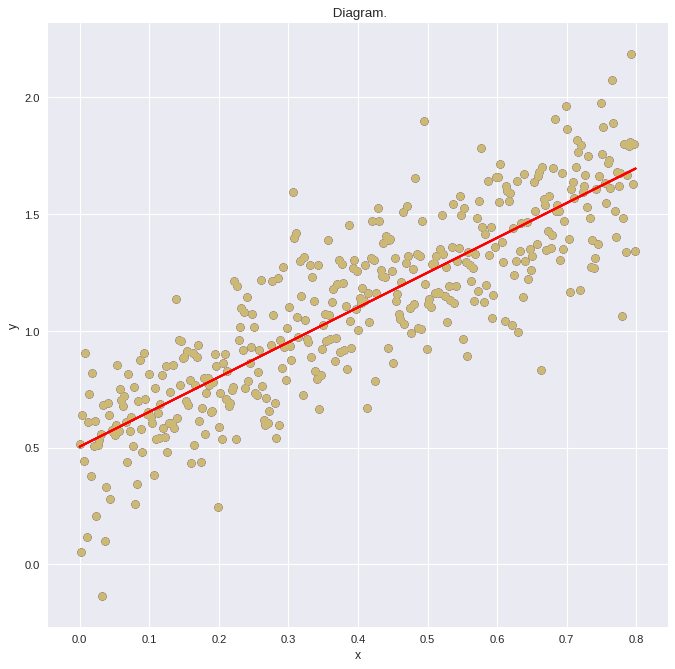

Done !!!


In [4]:
# _*_ coding: utf-8 _*_

import matplotlib.pyplot as plt

import tensorflow as tf

import numpy as np

import os

BATCH_SIZE = 400

TRAIN_TF_REDOCRD_FILE = 'train.tfrecords'
TEST_TF_REDOCRD_FILE = 'test.tfrecords'

MAX_STEPS = 500

LOG_DIR = './log'
MODELS_DIR = LOG_DIR + '/models/test_model.ckpt'


#input
with tf.name_scope('input'):
    with tf.name_scope('x'):
        x = tf.placeholder(tf.float32, shape = (BATCH_SIZE,), name = "x")
        #print(x)
    with tf.name_scope('y_'):
        y_ = tf.placeholder(tf.float32, shape = (BATCH_SIZE,), name = "y_")

        
# layer
with tf.name_scope('layer'):
    with tf.name_scope('weights'):
        Weights = tf.Variable(np.random.normal())
        tf.summary.histogram('Weights' ,Weights)
    with tf.name_scope('biases'):
        biases = tf.Variable(np.random.normal())
        tf.summary.histogram('biases' ,biases)
        
with tf.name_scope('Result'):
    #权值与x相乘并加偏差
    #y = Weights * x + biases
    y = tf.add(tf.multiply(Weights,x),biases,name = 'out')

#Mean Squared Error)
with tf.name_scope('Mean_Squared_Error'):
    #方差，(y-y_)平方，求和，取均值
    loss = tf.reduce_mean(tf.square(y-y_),name='loss')
    tf.summary.scalar('loss', loss)
    
#Optimizer
with tf.name_scope('train'):
    #定义梯度下降法优化函数优化，步长为0.5
    optimizer = tf.train.GradientDescentOptimizer(0.8)
    #tf.summary.scalar('optimizer', optimizer)
    train_step = optimizer.minimize(loss)

  
def feed_dict(train,batch_sieze):
    #xs, ys =x_data[0], x_data[1]
    if train:
      data = read_and_decode_two(TRAIN_TF_REDOCRD_FILE,batch_sieze)
    else :
      data = read_and_decode_two(TEST_TF_REDOCRD_FILE,batch_sieze)

    next_element = data.make_one_shot_iterator().get_next()

    return next_element

#Xs,Ys = feed_dict(True,BATCH_SIZE)

merged = tf.summary.merge_all()

step = 0

#session
with  tf.Session() as sess:
  
    init = tf.global_variables_initializer()
    
    #create FileWriter and loadd graph
    train_writer = tf.summary.FileWriter(LOG_DIR+'/train', sess.graph)
    test_writer = tf.summary.FileWriter(LOG_DIR+'/test')
    
    sess.run(init)
    
    plt.figure(figsize=(10, 10), dpi=80)
    plt.ion()

    #Save
    saver = tf.train.Saver()
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    plt.title(" Diagram.")
    plt.xlabel("x")
    plt.ylabel("y")
    try:
        while not coord.should_stop() and  step <= MAX_STEPS:

            if False:
              x_data ,y_data = sess.run(fetches=feed_dict(True,BATCH_SIZE))
              summary,y_re,loss_value, _ = sess.run([merged,y,loss,train_step],feed_dict={x:x_data,y_:y_data})
              test_writer.add_summary(summary, step)
              print("At %d  step(s), loss is %g, weight is %g , bias is %g" %(step, loss_value,sess.run(Weights),sess.run(biases)))
            else:
              if step % 100 == 99:
                    x_data ,y_data = sess.run(fetches=feed_dict(True,BATCH_SIZE))
                    run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                    run_metadata = tf.RunMetadata()
                    summary,y_re,loss_value, _ = sess.run([merged,y,loss,train_step],feed_dict={x:x_data,y_:y_data},options=run_options,run_metadata=run_metadata)
                    train_writer.add_run_metadata(run_metadata, 'step%03d' % step)
                    train_writer.add_summary(summary, step)
                    print('Adding run metadata fro ', step)
                    print("After %d  step(s), loss is %g, weight is %g , bias is %g" %(step, loss_value,sess.run(Weights),sess.run(biases)))
                    saver.save(sess,MODELS_DIR, global_step=step)
              else:
                  x_data ,y_data = sess.run(fetches=feed_dict(True,BATCH_SIZE))
                  summary,y_re,loss_value, _ = sess.run([merged,y,loss,train_step],feed_dict={x:x_data,y_:y_data})
                  train_writer.add_summary(summary, step)
            
            if step % 50 == 0:
                print("After %d  step(s), loss is %g, weight is %g , bias is %g" %(step, loss_value,sess.run(Weights),sess.run(biases)))

            step += 1
            #print("y_re")
            #print(y_re)
            if step % 100 == 0:
                plt.scatter(x_data,y_data)
                plt.plot(x_data,y_re,color='red')
    except tf.errors.OutOfRangeError:
        print('done!')
    finally:
        coord.request_stop()
    coord.join(threads)

    plt.ioff()
    plt.show()
    
    #close FileWriter
    train_writer.close()
    test_writer.close()

print("Done !!!")




# **Freeze Graph**

In [5]:
from tensorflow.python.framework import graph_util

LOG_DIR = './log'
MODELS_DIR = LOG_DIR + '/models/'

def freeze_graph(model_folder,modelsName):
    checkpoint = tf.train.get_checkpoint_state(model_folder)
    input_checkpoint = checkpoint.model_checkpoint_path
    #print(checkpoint)
    #print(input_checkpoint)
    absolute_model_folder = "/".join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_folder + "/"+modelsName+".pb"
    #print(absolute_model_folder)
    #print(output_graph)
    
    output_node_names = "Result/out" #now is bad!!!!
    
    clear_devices = True
    
    saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)
    #print(saver)
    
    graph = tf.get_default_graph()
    
    input_graph_def = graph.as_graph_def()
    
    with tf.Session() as sess:
        saver.restore(sess, input_checkpoint)
 
        # We use a built-in TF helper to export variables to constant
        output_graph_def = graph_util.convert_variables_to_constants(
            sess, 
            input_graph_def, 
            output_node_names.split(",") # We split on comma for convenience
        ) 
 
        # Finally we serialize and dump the output graph to the filesystem
        with tf.gfile.GFile(output_graph, "wb") as f:
            f.write(output_graph_def.SerializeToString())
        print("%d ops in the final graph." % len(output_graph_def.node))
        #print(output_graph_def.node)
    
with tf.Session() as sess:
    freeze_graph(MODELS_DIR,'test')
    #print(MODELS_DIR)

INFO:tensorflow:Restoring parameters from ./log/models/test_model.ckpt-499
INFO:tensorflow:Froze 2 variables.
INFO:tensorflow:Converted 2 variables to const ops.
7 ops in the final graph.


# **Load pb Model**

In [6]:
import argparse
import os
import sys

import numpy as np 
import tensorflow as tf
from tensorflow.python.platform import gfile

LOG_DIR = './log'
MODELS_DIR = LOG_DIR + '/models/'

def load(MODELS_DIR,fileName,sess):
  graph = tf.get_default_graph()
  graphdef = graph.as_graph_def()
  graphdef.ParseFromString(gfile.FastGFile(MODELS_DIR+fileName, "rb").read())
  #print(MODELS_DIR+fileName)
  _ = tf.import_graph_def(graphdef)
  summary_write = tf.summary.FileWriter(LOG_DIR + '/graph', sess.graph)
  summary_write.close()
  
  return graph
  
X =  np.linspace(0, 1, 400).astype(np.int32).reshape(400)

with tf.Session() as sess:
  
    graph = load(MODELS_DIR,'test.pb',sess)
    #for op in graph.get_operations():
        #rint(op.name,op.values())
        
    x = graph.get_tensor_by_name('import/input/x/x:0')
    y = graph.get_tensor_by_name('import/Result/out:0')

    y_out = sess.run(y, feed_dict={x: X })

    #print(np.unique(y_out))
    print("weight is %g , bias is %g" %(np.unique(y_out)[0],(np.unique(y_out)[1])-np.unique(y_out)[0]))






Instructions for updating:
Use tf.gfile.GFile.
weight is 0.50392 , bias is 1.49072


# **TensorBoard**

In [7]:
#https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

LOG_DIR = './log'
get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))

get_ipython().system_raw('./ngrok http 6006 &')


! curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"



--2018-10-31 00:41:57--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.21.103.149, 52.203.66.95, 52.207.5.158, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.21.103.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  9.77MB/s    in 0.5s    

2018-10-31 00:42:03 (9.77 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
http://403ae5d0.ngrok.io
